In [69]:
from rtlsdr import RtlSdr  
import numpy as np  
import scipy.signal as signal
import re

import matplotlib.pyplot as plt
from scipy.signal import find_peaks


sdr = RtlSdr()

In [2]:
F_station = int(433.42e6)   # device
F_offset = 250000         # Offset to capture at  
# We capture at an offset to avoid DC spike
Fc = F_station - F_offset # Capture center frequency  
Fs = int(1140000)         # Sample rate  
N = int(8192000)            # Samples to capture  

# configure device
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'

# Read samples
samples = sdr.read_samples(N)

# Clean up the SDR device
sdr.close()  
del(sdr)

# Convert samples to a numpy array
x1 = np.array(samples).astype("complex64")

(-570000.0, 570000.0)

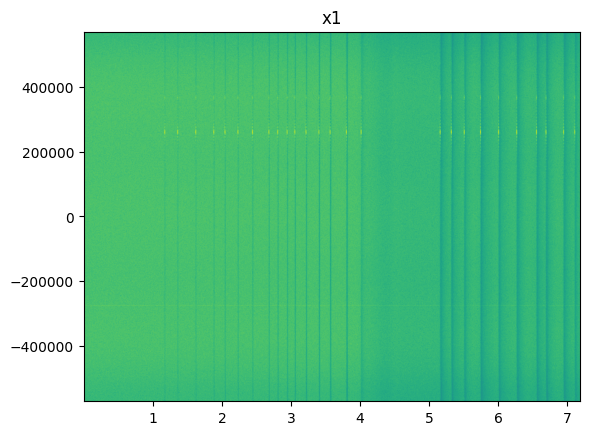

In [3]:
plt.specgram(x1, NFFT=2048, Fs=Fs)  
plt.title("x1")  
plt.ylim(-Fs/2, Fs/2) 

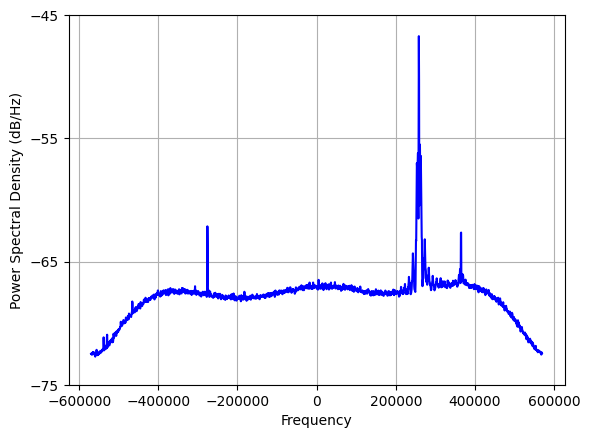

In [7]:
pxx_, freqs_, = plt.psd(x1, NFFT=2048, Fs=Fs, color="blue")  
plt.ticklabel_format(style='plain', axis='y' )  

In [14]:
pks, _ = find_peaks(pxx_, height=1e-5)
F_offset_new = freqs_[pks][0]

In [15]:
# To mix the data down, generate a digital complex exponential 
# (with the same length as x1) with phase -F_offset/Fs
fc1 = np.exp(-1.0j*2.0*np.pi* F_offset_new/Fs*np.arange(len(x1)))  
# Now, just multiply x1 and the digital complex expontential
x2 = x1 * fc1  

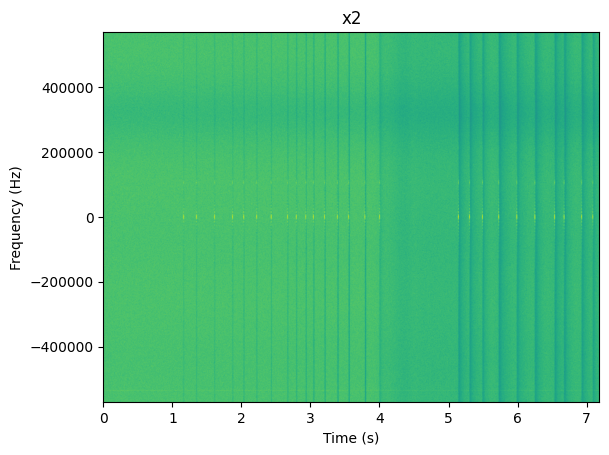

In [16]:
plt.specgram(x2, NFFT=2048, Fs=Fs)  
plt.title("x2")  
plt.xlabel("Time (s)")  
plt.ylabel("Frequency (Hz)")  
plt.ylim(-Fs/2, Fs/2)  
plt.xlim(0,len(x2)/Fs)  
plt.ticklabel_format(style='plain', axis='y' ) 

In [39]:
# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 1e3  
n_taps = 64  
# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(Fs/2-f_bw)/4, Fs/2], [1,0], Hz=Fs)  
x3 = signal.lfilter(lpf, 1.0, x2)

dec_rate = int(Fs / f_bw)  
x4 = x3[0::dec_rate]  
# Calculate the new sampling rate
Fs_y = Fs/dec_rate  

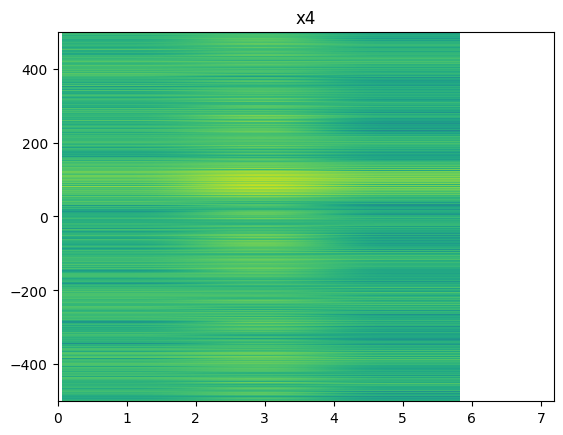

In [40]:
plt.specgram(x4, NFFT=2048, Fs=Fs_y)  
plt.title("x4")  
plt.ylim(-Fs_y/2, Fs_y/2)  
plt.xlim(0,len(x4)/Fs_y)  
plt.ticklabel_format(style='plain', axis='y' )  

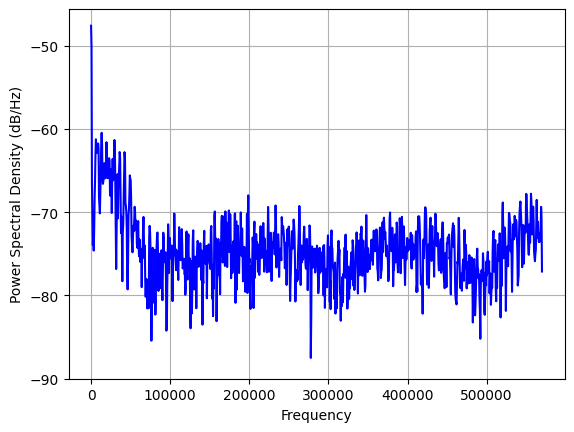

In [41]:
x5 = np.abs(x4)
plt.psd(x5, NFFT=2048, Fs=Fs, color="blue")  
plt.ticklabel_format(style='plain', axis='y' )  

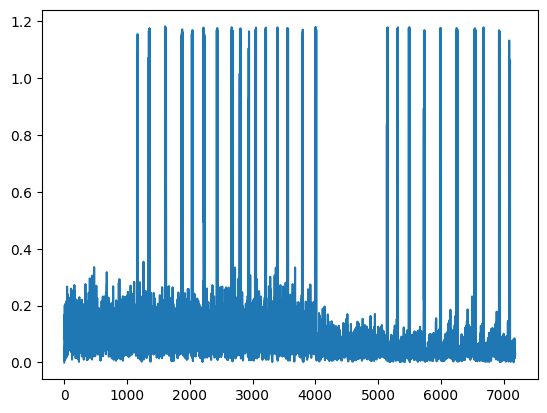

In [42]:
plt.plot(x5)

In [44]:
data = x5

# "calculate" noise level from begining of a file
noise = max(data[0:1000])

In [46]:
# set baudrate for OOK analyzer, it will calculate original
# signal baudrate
baud = 5000 

In [47]:
# create median vector
median = signal.medfilt(data)

In [51]:
# every signal above will be set to 1, every below to 0
# use additional noise floor
normalized = np.where(median > np.mean(median) + noise, 1, 0)

In [61]:
# trim trailing and leading zeros
normalized_no_zeros = np.trim_zeros(normalized)

In [74]:
# convert above [1,1, ... , 0, 0, ... , 1,1] to string 11...00...11
bin_str = np.char.mod('%d', normalized_no_zeros).tobytes()

In [87]:
# regexp for data rates
zero={}
zero[1] = re.compile("1{3}0")
zero[2] = re.compile("1{6}0")
zero[4] = re.compile("1{12}0")
zero[8] = re.compile("1{24}0")

one={}
one[1]  = re.compile("10{3,}")
one[2]  = re.compile("10{6,}")
one[4]  = re.compile("10{12,}")
one[8]  = re.compile("10{24,}")

def analyze_ook(data, baud, bin_input=False):
   bin_str = ""

   # if input is already a "bin string" e.g. "11110001001010101", do nothing
   # else convert raw data to above string
   if (not bin_input): 
      bin_str = ''.join(format(ord(byte), '08b') for byte in data)
   else:
      bin_str = data

   # determine speed of data by checking every speed regexp
   # then sort tupple and return one with biggest match
   speed = sorted(zero, key=lambda obj:zero[obj].subn('', bin_str))[0]

   # use matched regex to normalize data into _ZERO_ and _ONE_, remove every
   # tramsnission glitch at the end by removing 1 and 0 orphans
   normalized_bin_str = re.sub('[1,0]', '', zero[speed].sub('_ZERO_', one[speed].sub('_ONE_', bin_str)))

   # change back normalized string with '_ZERO_', '_ONE_' to '1' and '0'
   decoded = re.sub('_ZERO_', '1', re.sub('_ONE_', '0', normalized_bin_str))
  
   # only show logner ones
   if (len(decoded) < 4):
      return

   # present data
   print("Packet len: {} speed: {} OOK decoded: {}".format(len(bin_str) / 8, baud / speed, decoded))
   print("Original: {}".format(bin_str))

# split string into packets separted by high count of '0', 20 is enought for
# 2400 to 9600 data rate
for splitted in re.split('0{20,}', str(bin_str)):
   if (len(splitted) > 0):
      # make sure that we've got some zeroes at the end for regexp
      splitted+="0" * 20
      # analyze and print
      analyze_ook(splitted, baud, bin_input=True)

Packet len: 9660.25 speed: 5000.0 OOK decoded: b'\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\x\

In [76]:
str(bin_str)

"b'1\\x00\\x00\\x000\\x00\\x00\\x001\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x00\\x00\\x000\\x0